In [1]:
import pandas as pd

In [2]:
# Load node and edge data from https://www.cs.utah.edu/~lifeifei/SpatialDataset.htm
df_edges = pd.read_csv("cal.cedge", delim_whitespace=True, names=["edgeid", "start_nodeid", "end_nodeid", "distance"], index_col="edgeid")
df_nodes = pd.read_csv("cal.cnode", delim_whitespace=True, names=["nodeid", "longitude", "latitude"], index_col="nodeid")

In [3]:
df_nodes.describe()

,longitude,latitude
count,21048.000000,21048.000000
mean,-119.873018,37.061995
std,2.407934,2.595064
min,-124.389343,32.541302
25%,-121.835472,34.735370
50%,-120.192913,37.008939
75%,-117.933136,39.192312
max,-114.294258,42.017231


In [4]:
df_nodes.head()

,longitude,latitude
nodeid,,
0,-121.904167,41.974556
1,-121.902153,41.974766
2,-121.896790,41.988075
3,-121.889603,41.998032
4,-121.886681,42.008739


In [5]:
df_edges.describe()

,start_nodeid,end_nodeid,distance
count,21693.000000,21693.000000,21693.000000
mean,10579.016826,10598.322593,0.016186
std,6074.574130,6076.851996,0.016546
min,0.000000,1.000000,0.000502
25%,5324.000000,5346.000000,0.007197
50%,10613.000000,10630.000000,0.011900
75%,15849.000000,15871.000000,0.019249
max,21045.000000,21047.000000,0.299789


In [6]:
df_edges.head()

,start_nodeid,end_nodeid,distance
edgeid,,,
0,0,1,0.002025
1,0,6,0.005952
2,1,2,0.014350
3,2,3,0.012279
4,3,4,0.011099


In [7]:
import urllib.request
import json
from math import ceil

downloaded = True

if downloaded:
    df_nodes = pd.read_csv("nodes_with_elevation.csv").set_index("nodeid")
else:

    d_ar = [{}]*len(df_nodes)
    for i, long_lat in enumerate(df_nodes[["longitude", "latitude"]].to_numpy()):
        d_ar[i] = {"latitude": long_lat[1],"longitude": long_lat[0]}


    import requests
    
    # Query elevation information for the nodes from Open Elevation
    url = "https://api.open-elevation.com/api/v1/lookup"
    queries_per_req = 100
    num_chunks = ceil(len(df_nodes) / queries_per_req)

    from concurrent.futures import ThreadPoolExecutor

    def get(i):
        start = i * queries_per_req
        end = min(len(df_nodes), (i+1) * queries_per_req)
        json = {"locations": d_ar[start: end]}
        status_code = -1
        # for some reason these will timeout frequently so we must retry
        while status_code != 200:
            print(f"Querying index [{start} to {end}) for chunk {i}")
            r = requests.post(url,
                          json=json, 
                          headers={'Accept': 'application/json', 'Content-Type': 'application/json'})
            status_code = r.status_code
            if status_code != 200:
                print(f"Failed: Chunk {i}. Retrying...")
        returned_elevations = r.json()["results"]
        print(f"Success: Chunk {i}")
        return returned_elevations

    with ThreadPoolExecutor(max_workers=1000) as pool:
        elevations = list(pool.map(get, range(num_chunks)))

    import itertools
    all_elevations = list(itertools.chain(*elevations))

    assert len(all_elevations) == len(df_nodes)

    df_elevations = pd.DataFrame(all_elevations)

    df_nodes["elevation"] = df_elevations["elevation"]

    df_nodes.to_csv("nodes_with_elevation.csv")

No handles with labels found to put in legend.


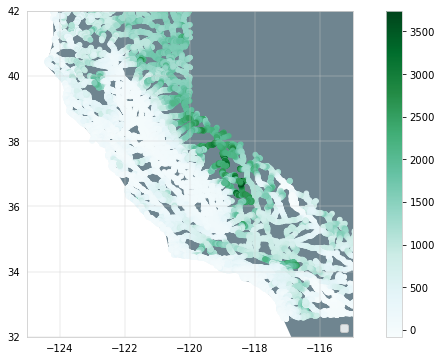

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
lat_low, lat_high = 32, 42
long_low, long_high = -125, -115


#cmap = sns.cubehelix_palette(as_cmap=True)
#cmap = sns.light_palette("BuGn", as_cmap=True)

cmap = matplotlib.cm.get_cmap("BuGn")

# PLOT CALIFORNIA SHAPE
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color="#6f8590")

# PLOT ELEVATION
points = ax.scatter(df_nodes["longitude"], df_nodes["latitude"], c=df_nodes["elevation"], s=20, cmap="BuGn")
fig.colorbar(points)

ax.set(xlim=[long_low, long_high], ylim=[lat_low, lat_high])
ax.legend(loc="lower right")

In [9]:
# select the portion we want
lat_low, lat_high = 36.7, 39.3
long_low, long_high = -122.5, -119.5
df_ba_nodes = df_nodes[(lat_low <= df_nodes["latitude"])
                     & (df_nodes["latitude"] <= lat_high)
                     & (long_low <= df_nodes["longitude"])
                     & (df_nodes["longitude"]<= long_high)]

In [10]:
# get the edges between our selected nodes
df_ba_edges = df_edges.reset_index().merge(df_ba_nodes, how="inner", left_on="start_nodeid", right_on="nodeid")
df_ba_edges = df_ba_edges.merge(df_ba_nodes, how="inner", left_on="end_nodeid", right_on="nodeid")
df_ba_edges.head()

,edgeid,start_nodeid,end_nodeid,distance,longitude_x,latitude_x,elevation_x,longitude_y,latitude_y,elevation_y
0,4786,4700,4785,0.002567,-122.486511,39.296139,372,-122.484161,39.297173,372
1,4787,4700,5139,0.009115,-122.486511,39.296139,372,-122.489113,39.287403,377
2,4814,4728,4729,0.002292,-121.658623,39.282276,24,-121.658493,39.279987,26
3,4815,4729,4730,0.000676,-121.658493,39.279987,26,-121.658203,39.279377,26
4,4816,4730,4749,0.005786,-121.658203,39.279377,26,-121.655777,39.274124,23


In [11]:
df_ba_edges.describe()

,edgeid,start_nodeid,end_nodeid,distance,longitude_x,latitude_x,elevation_x,longitude_y,latitude_y,elevation_y
count,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000
mean,8230.582138,8068.327395,8088.634197,0.015978,-121.169613,38.013215,449.648311,-121.168632,38.010909,451.961592
std,1736.139369,1690.510697,1692.140690,0.017080,0.877833,0.692518,650.010084,0.878245,0.692647,652.654127
min,4786.000000,4700.000000,4729.000000,0.000505,-122.499611,36.701443,-6.000000,-122.498901,36.701321,-6.000000
25%,6763.250000,6643.000000,6655.250000,0.007151,-121.977427,37.472746,30.000000,-121.978817,37.470679,31.000000
50%,8350.500000,8195.000000,8205.500000,0.011598,-121.261677,37.934856,121.500000,-121.261212,37.932367,123.000000
75%,9675.750000,9469.000000,9487.750000,0.018579,-120.448452,38.613493,598.000000,-120.447027,38.608282,600.500000
max,11896.000000,11632.000000,11633.000000,0.239678,-119.502434,39.299168,2911.000000,-119.502434,39.298203,2911.000000


In [12]:
# Use the mean of two endpoints as the longitude/latitude of an edge
df_ba_edges["mean_longitude"] = (df_ba_edges["longitude_x"] + df_ba_edges["longitude_y"]) / 2
df_ba_edges["mean_latitude"] = (df_ba_edges["latitude_x"] + df_ba_edges["latitude_y"]) / 2

In [13]:
assert df_ba_nodes.reset_index()["nodeid"].is_unique

In [14]:
old_to_new_nodeid = dict(zip(df_ba_nodes.reset_index()["nodeid"], df_ba_nodes.reset_index().index))

In [15]:
df_ba_nodes_new = df_ba_nodes.reset_index().replace({"nodeid": old_to_new_nodeid})
df_ba_edges_new = df_ba_edges.replace({"start_nodeid": old_to_new_nodeid, "end_nodeid": old_to_new_nodeid})

In [16]:
df_ba_edges_new

,edgeid,start_nodeid,end_nodeid,distance,longitude_x,latitude_x,elevation_x,longitude_y,latitude_y,elevation_y,mean_longitude,mean_latitude
0,4786,0,16,0.002567,-122.486511,39.296139,372,-122.484161,39.297173,372,-122.485336,39.296656
1,4787,0,120,0.009115,-122.486511,39.296139,372,-122.489113,39.287403,377,-122.487812,39.291771
2,4814,1,2,0.002292,-121.658623,39.282276,24,-121.658493,39.279987,26,-121.658558,39.281132
3,4815,2,3,0.000676,-121.658493,39.279987,26,-121.658203,39.279377,26,-121.658348,39.279682
4,4816,3,9,0.005786,-121.658203,39.279377,26,-121.655777,39.274124,23,-121.656990,39.276750
...,...,...,...,...,...,...,...,...,...,...,...,...
4317,11419,4192,4193,0.027616,-120.870293,36.741093,287,-120.861382,36.714954,351,-120.865837,36.728023
4318,11420,4193,4194,0.006178,-120.861382,36.714954,351,-120.858009,36.709778,354,-120.859696,36.712366
4319,11494,4197,4198,0.010985,-120.208832,36.719524,52,-120.210693,36.708698,49,-120.209763,36.714111
4320,11810,4199,4200,0.013133,-120.388031,36.728920,55,-120.387154,36.742023,53,-120.387592,36.735472


In [17]:
df_ba_nodes_new

,nodeid,longitude,latitude,elevation
0,0,-122.486511,39.296139,372
1,1,-121.658623,39.282276,24
2,2,-121.658493,39.279987,26
3,3,-121.658203,39.279377,26
4,4,-122.040871,39.284943,17
...,...,...,...,...
4199,4199,-120.388031,36.728920,55
4200,4200,-120.387154,36.742023,53
4201,4201,-120.382507,36.751873,52
4202,4202,-121.280357,36.717670,217


In [18]:
df_ba_nodes_new.to_csv("ba_nodes_new.csv")
df_ba_edges_new.to_csv("ba_edges_new.csv")

In [19]:
# Choose a few reference points
santa_cruz = (-122.045158, 36.961494)
santa_cruz_nodeid = df_nodes.reset_index().set_index(["longitude", "latitude"]).loc[santa_cruz, "nodeid"]

lake_tahoe = (-120.0, 38.913666)
lake_tahoe_nodeid = df_nodes.reset_index().set_index(["longitude", "latitude"]).loc[lake_tahoe, "nodeid"]

In [20]:
lake_tahoe_nodeid

5692

In [21]:
santa_cruz_nodeid

10585

In [22]:
new_start_nodeid = old_to_new_nodeid[santa_cruz_nodeid]
new_goal_nodeid = old_to_new_nodeid[lake_tahoe_nodeid]

In [23]:
print(new_start_nodeid)
print(new_goal_nodeid)

3939
446


In [24]:
df_ba_nodes_new.loc[new_start_nodeid]

nodeid       3939.000000
longitude    -122.045158
latitude       36.961494
elevation      18.000000
Name: 3939, dtype: float64

In [25]:
df_ba_nodes_new.loc[new_goal_nodeid]

nodeid        446.000000
longitude    -120.000000
latitude       38.913666
elevation    1915.000000
Name: 446, dtype: float64

[]

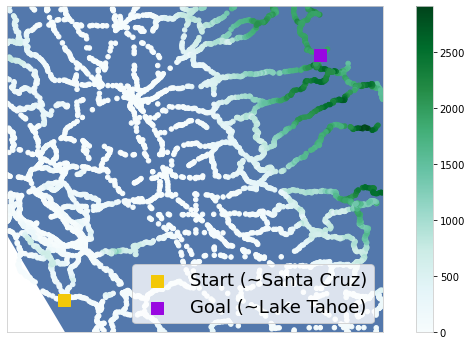

In [26]:
# Let's visualize our subset of nodes selected
fig, ax = plt.subplots(figsize=(12, 6))

#cmap = sns.cubehelix_palette(as_cmap=True)
#cmap = sns.light_palette("BuGn", as_cmap=True)
import matplotlib
cmap = matplotlib.cm.get_cmap("BuGn")

# PLOT CALIFORNIA
world.plot(ax=ax, color="#5378ac", alpha=1.)

# PLOT ELEVATION
points = ax.scatter(df_ba_nodes_new["longitude"], df_ba_nodes_new["latitude"], c=df_ba_nodes_new["elevation"], s=20, cmap="BuGn")
fig.colorbar(points)

# PLOT CITIES
cities = ["Start (~Santa Cruz)", "Goal (~Lake Tahoe)"]
coords = [santa_cruz, lake_tahoe] # longitude, latitude
colors = ['#F3C807', "#9907E1"]
markers= ["s", "s"]

for city, coord, color, marker in zip(cities, coords, colors, markers):
    ax.scatter(x=coord[0], y=coord[1], label=city, color=color, marker=marker, s=150)

#i = 10585
#i = 5692
#ax.scatter(x=df_nodes["longitude"][i], y=df_nodes["latitude"][i], color="k")    

ax.set(xlim=[long_low, long_high], ylim=[lat_low, lat_high])
ax.legend(loc="lower right", prop={'size': 18})
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

In [27]:
from bax.util.graph import make_vertices, make_edges
import numpy as np
positions = df_ba_nodes_new[["longitude", "latitude"]].to_numpy()
edge_nodes = df_ba_edges_new[["start_nodeid", "end_nodeid"]].to_numpy()

has_edge = np.zeros((len(positions), len(positions)))
# make undirected edges
has_edge[edge_nodes[:, 0], edge_nodes[:, 1]] = 1
has_edge[edge_nodes[:, 1], edge_nodes[:, 0]] = 1

vertices = make_vertices(positions, has_edge)
edges = make_edges(vertices)

In [28]:
# find connected components
visited = [False for _ in vertices]
components = []
for v in vertices:
    if visited[v.index]:
        continue
    # begin dfs for connected components otherwise
    stack = [v]
    component = []
    while len(stack) > 0:
        v = stack.pop()
        component.append(v)
        visited[v.index] = True
        for n in v.neighbors:
            if not visited[n.index]:
                stack.append(n)
    components.append(component)

In [29]:
[len(c) for c in components]

[4288, 31, 5, 2]

In [30]:
biggest_component = [v.index for v in components[0]]

In [31]:
new_start_nodeid in biggest_component

True

In [32]:
new_goal_nodeid in biggest_component

True

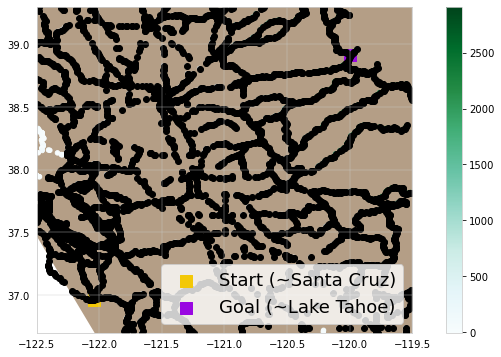

In [33]:
# Let's visualize just the biggest connected component to make sure it's reasonable
fig, ax = plt.subplots(figsize=(12, 6))

#cmap = sns.cubehelix_palette(as_cmap=True)
#cmap = sns.light_palette("BuGn", as_cmap=True)
import matplotlib
cmap = matplotlib.cm.get_cmap("BuGn")

# PLOT CALIFORNIA
world.plot(ax=ax, color="#a28668", alpha=0.8)

# PLOT ELEVATION
points = ax.scatter(df_ba_nodes_new["longitude"], df_ba_nodes_new["latitude"], c=df_ba_nodes_new["elevation"], s=20, cmap="BuGn")
fig.colorbar(points)

# PLOT CITIES
cities = ["Start (~Santa Cruz)", "Goal (~Lake Tahoe)"]
coords = [santa_cruz, lake_tahoe] # longitude, latitude
colors = ['#F3C807', "#9907E1"]
markers= ["s", "s"]

for city, coord, color, marker in zip(cities, coords, colors, markers):
    ax.scatter(x=coord[0], y=coord[1], label=city, color=color, marker=marker, s=150)

#i = 10585
#i = 5692
#ax.scatter(x=df_nodes["longitude"][i], y=df_nodes["latitude"][i], color="k")

# scatter biggest connected component
points = ax.scatter(df_ba_nodes_new.loc[biggest_component, "longitude"],
                    df_ba_nodes_new.loc[biggest_component, "latitude"],
                    c="k")

ax.set(xlim=[long_low, long_high], ylim=[lat_low, lat_high])
ax.legend(loc="lower right", prop={'size': 18})

In [34]:
def distance(u, v):
    return 1

def dijkstras(start, goal, vertices):
    import heapq
    """Dijkstra's algorithm."""
    explored = [False for _ in range(len(vertices))]
    min_cost = [float("inf") for _ in range(len(vertices))]
    prev = [None for _ in range(len(vertices))]
    to_explore = [(0, start)]  # initialize priority queue
    num_expansions = 0
    num_queries = 0

    while len(to_explore) > 0:
        best_cost, current = heapq.heappop(to_explore)
        if explored[current.index]:
            # the same node could appear in the pqueue multiple times with different costs
            continue
        explored[current.index] = True
        num_expansions += 1
        if current.index == goal.index:
            print(
                f"Found goal after {num_expansions} expansions and {num_queries} queries with estimated cost {best_cost}"
            )
#             best_path = [
#                 self.vertices[i] for i in backtrack_indices(current.index, prev)
#             ]

#             def true_cost_of_path(path):
#                 cost = 0
#                 for i in range(len(path) - 1):
#                     cost += self.params.true_cost(path[i], path[i + 1])[0]
#                 print("true cost", cost)

#             true_cost_of_path(best_path)
#             return best_cost, best_path
            return

        for neighbor in current.neighbors:
            num_queries += 1
            step_cost = distance(current, neighbor)
            if (not explored[neighbor.index]) and (
                best_cost + step_cost < min_cost[neighbor.index]
            ):
                heapq.heappush(
                    to_explore, (best_cost + step_cost, neighbor)
                )  # push by cost
                min_cost[neighbor.index] = best_cost + step_cost
                prev[neighbor.index] = current.index

    print("No path exists to goal")
    return float("inf"), []

In [35]:
start = vertices[new_start_nodeid]
goal = vertices[new_goal_nodeid]

In [36]:
# Let's make sure dijkstra's algorithm works on this graph just in case
dijkstras(start, goal, vertices)

Found goal after 4093 expansions and 8428 queries with estimated cost 261
